## Preparation and set-up

In [2]:
#It's for google colab usage on google drive.
#Ignore or change folder path that corresponds to your environment.
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

COLAB_PATH = '/content/drive/My Drive/TIC4003/VaRSpark'

import sys, os
sys.path.append(COLAB_PATH)
print(sys.path)
## change directory to the path above
os.chdir(COLAB_PATH)

Mounted at /content/drive
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/TIC4003/VaRSpark', '/content/drive/My Drive/TIC4003/VaRSpark']


In [3]:
#Installing pyspark
!pip install pyspark

     |████████████████████████████████| 212.3MB 68kB/s 
     |████████████████████████████████| 204kB 39.1MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=22c08655704601a1a9a359d1a81f40420cfe0387dd7802b40c49751d213325f3
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [4]:
!pip install investpy

     |████████████████████████████████| 4.4MB 5.5MB/s 
     |████████████████████████████████| 245kB 48.0MB/s 
     |████████████████████████████████| 5.5MB 30.1MB/s 
     |████████████████████████████████| 512kB 32.4MB/s 
  Created wheel for investpy: filename=investpy-1.0.6-cp37-none-any.whl size=4485151 sha256=9bc20bed1475c56d1d9c147904bba8308269889667842aeafa39f7e38ac7ceb2
  Stored in directory: /root/.cache/pip/wheels/13/5f/65/a9e30255faec3c0b7dd11b40fa1042c61c5b0cfbbb9797c474
Successfully built investpy
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Found existing installation: pytz 2018.9
    Uninstalling pytz-2018.9:
      Successfully uninstalled pytz-2018.9


In [5]:
!pip install stats

     |████████████████████████████████| 133kB 4.4MB/s 
  Created wheel for stats: filename=stats-0.1.2a0-cp37-none-any.whl size=24279 sha256=b6a4de1631b824e59f021d9fdef5a8db727c8d87a50c1d533eb473fd07aec5eb
  Stored in directory: /root/.cache/pip/wheels/1f/64/c9/da1748f4ce76935afc665178ead2217b90147bac5ca096aa56
Successfully built stats


### Import libraries

In [6]:
#Import libraries
import pandas as pd
import numpy as np
from random import choice
import time
from datetime import datetime
import pandas_datareader.data as web
import investpy

import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression as skLinearRegression

%matplotlib inline

In [7]:
#import libraries related with pyspark
import os, json, math, pyspark
from pyspark import SparkContext
from pyspark.sql import Row, SparkSession, DataFrame
from pyspark.sql.types import * 
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.sql.functions import year, month

In [8]:
import warnings
warnings.filterwarnings("ignore")

## Downloading factor data

Downloaded factors as follows. I slightly modified from last time.

*   S&P500 (^GSPC)
*   Nasdaq (^IXIC)
*   Treasury Yield 30 Years (^TYX)
*   Brent Crude Oil (BZ=F)
*   Gold (GC=F)
*   US Dollar Index/USDX (DX-Y.NYB)
*   Bitcoin (BTC-USD)


In [ ]:
start = datetime(2010, 1, 1)
end = datetime(2020,12, 31)

In [ ]:
bitcoin_df = web.DataReader('BTC-USD', 'yahoo', start = start, end = end)['Close'].reset_index()
bitcoin_df.columns = ['Date', 'BTC-USD']

In [ ]:
factors_list = ['^GSPC', '^IXIC', '^TYX', 'BZ=F','GC=F','DX-Y.NYB']
factors_df = web.DataReader(factors_list, 'yahoo', start = start, end = end)['Close'].reset_index()

In [ ]:
factor_final_df = factors_df.merge(bitcoin_df, on='Date', how='inner')
factor_final_df = factor_final_df.fillna(method='ffill')
factor_final_df.to_csv('FactorsFinal.csv')

## Read stock price and factor data from csv files

After download stock price data, I just read data from csv files.

In [9]:
price1_df = pd.read_csv('USStockPrices1.csv')
price2_df = pd.read_csv('USStockPrices2.csv')
price3_df = pd.read_csv('USStockPrices3.csv')
price4_df = pd.read_csv('USStockPrices4.csv')
price5_df = pd.read_csv('USStockPrices5.csv')

In [10]:
del price1_df['Unnamed: 0']
del price2_df['Unnamed: 0']
del price3_df['Unnamed: 0']
del price4_df['Unnamed: 0']
del price5_df['Unnamed: 0']

In [11]:
price_df = price1_df.merge(price2_df, how='outer', on='Date')
price_df = price_df.merge(price3_df, how='outer', on='Date')
price_df = price_df.merge(price4_df, how='outer', on='Date')
price_df = price_df.merge(price5_df, how='outer', on='Date')

In [68]:
price_df

,BA,GM,CVX,C,BAC,T,CAT,INTC,MSFT,AA,F,EBAY,DIS,CSCO,DE,FDX,GIS,GLW,GT,GS,JPM,KMB,KHC,KO,MCD,LLY,ORCL,MRK,MSI,MMM,ODP,CAKFF,PMMAF,VRTX,MNST,TEVA,FITB,SHLDQ,CTAS,ADSK,...,DB,MT,UL,YPF,TRI,TLK,ENB,MFC,RY,MBT,SA,UHT,UBA,USNA,WSR,LMAT,CDR,WNC,FOE,NEO,TPRE,AHH,EVTC,RMAX,NBHC,MMI,PARR,CCS,BOOT,SHAK,DEA,IRT,REI_y,NSA,CHCT,GNL,LNTH,GATX,MTDR,GMED
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,140.500000,33.310001,88.849998,51.130001,16.430000,34.349998,67.989998,33.990002,54.799999,23.333130,13.97,26.430000,102.980003,26.410000,76.080002,143.429993,57.459999,17.910000,32.009998,177.139999,63.619999,126.480003,72.699997,42.400002,117.580002,82.870003,35.750000,52.480000,67.129997,146.820007,54.900002,27.27,22.049999,122.889999,48.113335,65.300003,19.549999,19.790001,88.290001,60.310001,...,23.490000,12.120000,42.200001,15.80,37.110001,22.315001,32.900002,14.650000,52.400002,6.01,8.800000,48.840000,18.799999,63.605000,11.74,15.820000,45.033112,11.930000,10.75,7.560000,12.95,10.39,16.430000,36.520000,20.900000,27.730000,23.100000,17.020000,12.500000,38.549999,16.809999,7.48,6.83,16.780001,18.480000,23.969999,3.28,42.220001,19.340000,26.709999
2016-01-05,141.070007,32.430000,89.610001,50.860001,16.430000,34.590000,67.279999,33.830002,55.049999,22.275810,13.72,26.120001,100.900002,26.290001,76.519997,144.649994,57.200001,17.900000,30.700001,174.089996,63.730000,129.080002,73.389999,42.549999,119.199997,84.110001,35.639999,53.150002,66.389999,147.460007,57.799999,27.27,22.049999,123.449997,48.689999,65.860001,19.610001,19.950001,88.430000,60.389999,...,23.480000,12.780000,42.099998,15.73,37.040001,23.080000,32.889999,14.430000,52.070000,6.03,8.710000,50.330002,19.120001,62.900002,12.00,16.219999,46.423840,11.770000,10.58,7.240000,12.78,10.67,16.170000,36.540001,21.049999,27.889999,24.000000,17.049999,12.300000,39.009998,17.510000,7.46,6.72,17.100000,18.480000,23.790001,3.21,40.380001,18.820000,27.070000
2016-01-06,138.830002,31.270000,86.070000,50.119999,16.080000,34.060001,66.220001,33.080002,54.049999,20.689831,13.11,26.410000,100.360001,26.010000,75.660004,140.770004,56.730000,17.500000,30.350000,169.839996,62.810001,129.020004,73.529999,42.320000,118.400002,83.580002,35.820000,52.419998,65.430000,144.490005,57.099998,27.27,22.049999,122.230003,48.766666,64.959999,19.320000,19.020000,88.029999,59.540001,...,23.139999,11.730000,41.500000,14.98,37.009998,22.945000,31.670000,14.010000,50.840000,5.76,9.140000,51.070000,19.450001,63.084999,12.08,16.440001,46.754967,11.570000,10.05,7.070000,12.49,10.64,16.170000,36.360001,21.080000,27.590000,23.790001,15.990000,11.460000,38.330002,17.559999,7.50,5.56,17.530001,18.469999,23.280001,3.14,39.509998,17.290001,27.590000
2016-01-07,133.009995,29.990000,83.019997,47.560001,15.500000,33.509998,63.939999,31.840000,52.169998,19.872810,12.70,25.690001,99.500000,25.410000,74.989998,134.589996,55.110001,17.100000,28.709999,164.619995,60.270000,126.860001,71.900002,41.619999,115.660004,81.410004,35.040001,51.959999,64.110001,140.970001,56.500000,27.27,22.049999,114.959999,48.400002,64.489998,18.709999,18.360001,86.879997,55.980000,...,22.719999,11.190000,40.849998,14.74,35.290001,22.520000,31.000000,13.380000,49.869999,5.37,9.360000,49.799999,19.100000,61.650002,11.58,15.370000,45.496689,10.920000,9.52,6.850000,12.00,10.52,15.820000,35.730000,20.920000,26.389999,23.610001,15.600000,11.520000,36.200001,17.580000,7.32,5.03,17.350000,18.190001,22.410000,3.07,37.740002,15.910000,26.270000
2016-01-08,129.990005,29.530001,82.129997,46.130001,15.200000,33.540001,63.290001,31.510000,52.330002,19.392210,12.54,25.750000,99.250000,24.780001,73.760002,134.710007,55.290001,17.150000,28.139999,163.940002,58.919998,125.230003,71.180000,41.509998,115.480003,81.250000,34.650002,51.080002,64.250000,140.490005,53.500000,27.27,22.049999,110.709999,48.083332,63.700001,18.389999,18.030001,84.629997,55.060001,...,22.100000,10.320000,40.450001,14.65,35.540001,22.160000,31.709999,13.4

In [13]:
factor_df = pd.read_csv('FactorsFinal.csv')
del factor_df['Unnamed: 0']

## Data Clearning

Same as is in the textbook, I implemented data cleaning, such as eliminating stocks with less than 5 years of data, implementing ffill, then calculating rolling 2 weeks returns. While in the textbook, data cleaning is implemented by writing tedious codes, now we can implement data cleaning by Python's pandas very easily, such that I'll do so with pandas.

In [14]:
price_df = price_df[price_df['Date'].isin(factor_df['Date'])]
price_df = price_df.reset_index(drop=True)
factor_df = factor_df[factor_df['Date'].isin(price_df['Date'])]
factor_df = factor_df.reset_index(drop=True)

In [15]:
#eliminating stocks with many nan
price_df = price_df.dropna(thresh=260*5, axis=1)
#change datetype of Date
price_df['Date'] = price_df['Date'].astype("datetime64")
factor_df['Date'] = factor_df['Date'].astype("datetime64")

In [16]:
#Remain data only after 2016/1/1
price_df = price_df[price_df['Date'] >= datetime(2016,1,1)]
factor_df = factor_df[factor_df['Date'] >= datetime(2016,1,1)]

In [17]:
#Set date as index, then executing ffill (if no price is available, 
#just filling by previous price data)
price_df = price_df.set_index('Date')
price_df = price_df.fillna(method='ffill')

factor_df = factor_df.set_index('Date')
factor_df = factor_df.fillna(method='ffill')

In [18]:
#1 month change
price_pct_df = price_df.pct_change(20)
factor_pct_df = factor_df.pct_change(20)

In [19]:
#Eliminating many nan rows
price_pct_df = price_pct_df.dropna(thresh=1000, axis=0)
factor_pct_df = factor_pct_df.dropna(thresh=4, axis=0)
#Datatype handling
price_pct_df = price_pct_df.astype('float')
factor_pct_df = factor_pct_df.astype('float')

In [20]:
#renaming DX-Y.NYB, as pyspark cannot digest "."
factor_pct_df = factor_pct_df.rename(columns={'DX-Y.NYB':'DX-Y'})

In [21]:
price_pct_df.head()

,BA,GM,CVX,C,BAC,T,CAT,INTC,MSFT,AA,F,EBAY,DIS,CSCO,DE,FDX,GIS,GLW,GT,GS,JPM,KMB,KHC,KO,MCD,LLY,ORCL,MRK,MSI,MMM,ODP,CAKFF,PMMAF,VRTX,MNST,TEVA,FITB,SHLDQ,CTAS,ADSK,...,DB,MT,UL,YPF,TRI,TLK,ENB,MFC,RY,MBT,SA,UHT,UBA,USNA,WSR,LMAT,CDR,WNC,FOE,NEO,TPRE,AHH,EVTC,RMAX,NBHC,MMI,PARR,CCS,BOOT,SHAK,DEA,IRT,REI_y,NSA,CHCT,GNL,LNTH,GATX,MTDR,GMED
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-02-02,-0.163559,-0.109877,-0.085650,-0.209466,-0.194766,0.049782,-0.107663,-0.123272,-0.032847,-0.282183,-0.176092,-0.118804,-0.095747,-0.135555,-0.019716,-0.092589,-0.028890,0.010050,-0.110903,-0.143615,-0.103584,0.012097,0.044979,0.000943,0.054176,-0.079281,-0.011189,-0.039444,-0.041859,0.007152,-0.091075,0.0,-0.060726,-0.259663,-0.056949,-0.066769,-0.215857,-0.146539,-0.034545,-0.239098,...,-0.278842,-0.136139,0.046682,0.001899,-0.001078,0.067667,-0.000912,-0.113311,-0.046947,0.129784,-0.290909,0.030508,0.079787,-0.050075,-0.077513,-0.082174,0.048529,-0.103101,-0.176744,-0.119048,-0.145174,0.026949,-0.183810,-0.069003,-0.065072,-0.161197,-0.010390,-0.182139,-0.557600,-0.073671,0.066032,-0.100267,-0.306003,0.029201,-0.019480,-0.090113,-0.326219,-0.044765,-0.258014,-0.093598
2016-02-03,-0.136103,-0.108233,-0.055686,-0.206449,-0.206939,0.061579,-0.059602,-0.132722,-0.052498,-0.185545,-0.164723,-0.100306,-0.057086,-0.121339,-0.014506,-0.094504,-0.026748,0.026816,-0.090880,-0.122982,-0.099168,0.009994,0.020439,0.003995,0.019044,-0.095351,0.001403,-0.058326,-0.022744,0.034314,-0.124567,0.0,-0.060726,-0.239530,-0.076333,-0.084877,-0.216726,-0.126316,-0.041615,-0.179334,...,-0.290886,-0.117371,0.051069,0.033058,0.014309,0.051343,0.056248,-0.085932,-0.022470,0.208955,-0.211251,-0.002782,0.071653,-0.016455,-0.112500,-0.151048,0.017118,-0.052676,-0.156900,-0.120166,-0.128325,-0.005623,-0.171305,-0.124247,-0.066508,-0.197203,-0.044167,-0.171261,-0.387805,-0.064599,-0.003427,-0.100536,-0.238095,0.007602,-0.027056,-0.070618,-0.311526,0.029222,-0.199256,-0.109346
2016-02-04,-0.109630,-0.084106,-0.014872,-0.186153,-0.175995,0.072519,-0.003926,-0.100060,-0.037928,-0.034843,-0.120519,-0.110564,-0.049123,-0.094963,0.040180,-0.046601,-0.028380,0.077714,-0.090280,-0.078603,-0.070212,-0.002093,0.008432,0.004962,0.019088,-0.111271,0.017588,-0.073064,-0.018035,0.061942,-0.103327,0.0,-0.060726,-0.249611,-0.121941,-0.077894,-0.196170,-0.069926,-0.032489,-0.168458,...,-0.267070,0.056266,0.045060,0.136849,0.019724,0.084114,0.094727,-0.030692,0.015736,0.229167,-0.213348,-0.017035,0.037018,-0.031069,-0.122517,-0.163625,0.008499,-0.032844,-0.082587,-0.101839,-0.110488,-0.001880,-0.197279,-0.118262,-0.071632,-0.184487,-0.026061,-0.098186,-0.308901,-0.000783,-0.015376,-0.106667,-0.010791,-0.037650,-0.012453,-0.050258,-0.340764,0.104531,-0.105842,-0.127220
2016-02-05,-0.078566,-0.048349,-0.001686,-0.161901,-0.164516,0.100567,0.034095,-0.087940,-0.038528,-0.018138,-0.098425,-0.096925,-0.056281,-0.099174,0.045739,-0.019912,0.004718,0.072515,-0.052943,-0.049508,-0.041812,0.018051,0.012239,0.019702,-0.002248,-0.087090,0.018836,-0.049654,-0.020122,0.088671,-0.099115,0.0,-0.060726,-0.246608,-0.147865,-0.087300,-0.180652,-0.052288,-0.040976,-0.175241,...,-0.256602,0.000000,0.061200,0.161465,0.035704,0.116119,0.093226,0.008969,0.026068,0.296089,-0.206197,-0.007831,0.040314,-0.026764,-0.092401,-0.147690,0.016012,0.012821,-0.064076,-0.109489,-0.072500,0.003802,-0.204804,-0.105793,-0.060707,-0.195529,-0.074968,-0.114103,-0.276910,-0.058840,-0.029010,-0.103825,-0.011929,-0.044380,-0.025289,-0.012048,-0.384365,0.164282,-0.013199,-0.143510
2016-02-08,-0.080929,-0.028784,0.046999,-0.180360,-0.192763,0.106440,0.020382,-0.085370,-0.055800,-0.021066,-0.075758,-0.126990,-0.071839,-0.074657,0.044875,-0.032514,0.007777,0.047230,-0.063966,-0.089606,-0.040394,0.033538,0.000562,0.027463,0.004936,-0.086892,0.027706,-0.044049,-0.033619,0.095452,-0.074766,0.0,-0.060726,-0.259326,-0.183917,-0.106279,-0.195215,-0.072102,-0.023514,-0.210861,...,-0.296833,0.023256,

In [22]:
factor_pct_df.head()

,^GSPC,^IXIC,^TYX,BZ=F,GC=F,DX-Y,BTC-USD
Date,,,,,,,
2016-02-02,-0.054470,-0.078754,-0.104013,-0.120903,0.048554,0.000000,-0.135406
2016-02-03,-0.051658,-0.079157,-0.101627,-0.037891,0.058327,-0.021227,-0.143557
2016-02-04,-0.037588,-0.067456,-0.081633,0.006719,0.060170,-0.027324,-0.092078
2016-02-05,-0.032443,-0.069580,-0.083390,0.009185,0.045229,-0.012116,-0.156095
2016-02-08,-0.035686,-0.077500,-0.123288,-0.019970,0.091182,-0.019992,-0.176032


## Plotting factor returns data

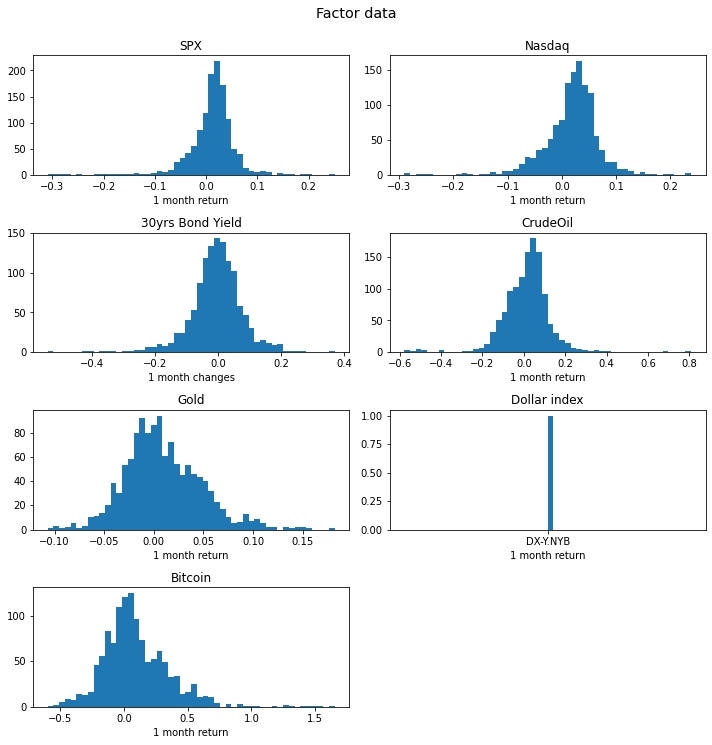

In [23]:
plt.figure(figsize=(10,10))
plt.suptitle("Factor data", fontsize="x-large", y=1.03)

plt.subplot(4,2,1)
plt.hist(data=factor_pct_df, x='^GSPC', bins=50)
plt.title("SPX")
plt.xlabel("1 month return")

plt.subplot(4,2,2)
plt.hist(data=factor_pct_df, x='^IXIC', bins=50)
plt.title("Nasdaq")
plt.xlabel("1 month return")

plt.subplot(4,2,3)
plt.hist(data=factor_pct_df, x='^TYX', bins=50)
plt.title("30yrs Bond Yield")
plt.xlabel("1 month changes")

plt.subplot(4,2,4)
plt.hist(data=factor_pct_df, x='BZ=F', bins=50)
plt.title("CrudeOil")
plt.xlabel("1 month return")

plt.subplot(4,2,5)
plt.hist(data=factor_pct_df, x='GC=F', bins=50)
plt.title("Gold")
plt.xlabel("1 month return")

plt.subplot(4,2,6)
plt.hist(data=factor_pct_df, x='DX-Y.NYB', bins=50)
plt.title("Dollar index")
plt.xlabel("1 month return")

plt.subplot(4,2,7)
plt.hist(data=factor_pct_df, x='BTC-USD', bins=50)
plt.title("Bitcoin")
plt.xlabel("1 month return")

plt.tight_layout()
plt.show()

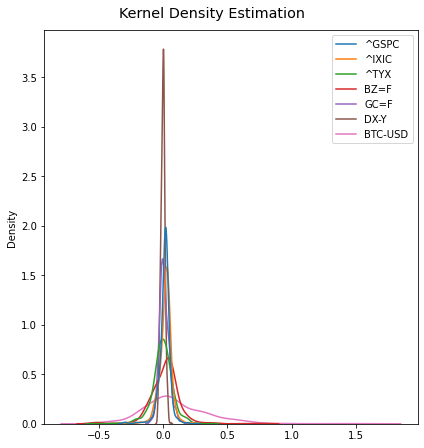

In [24]:
#Python has kernel density estimation function too.
plt.figure(figsize=(6,6))
plt.suptitle("Kernel Density Estimation", fontsize="x-large", y=1.03)
sns.kdeplot(data=factor_pct_df)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation among factors')

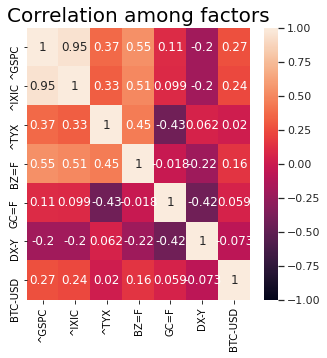

In [25]:
#Checking factor correlation. Very high correlation between SPX and Nasdaq.
factor_corr = factor_pct_df.corr()

fig, axs = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.0)
sns.heatmap(factor_corr,vmin=-1,vmax=1,annot=True, ax=axs).set_title("Correlation among factors", size=20)

In [26]:
#S&P500 and Nasdaq show very high correlation.
#To avoid multicolinearity, I dropped Nasdaq from factors.
factor_pct_df = factor_pct_df.drop('^IXIC',axis=1)

In [27]:
factor_pct_df.head()

,^GSPC,^TYX,BZ=F,GC=F,DX-Y,BTC-USD
Date,,,,,,
2016-02-02,-0.054470,-0.104013,-0.120903,0.048554,0.000000,-0.135406
2016-02-03,-0.051658,-0.101627,-0.037891,0.058327,-0.021227,-0.143557
2016-02-04,-0.037588,-0.081633,0.006719,0.060170,-0.027324,-0.092078
2016-02-05,-0.032443,-0.083390,0.009185,0.045229,-0.012116,-0.156095
2016-02-08,-0.035686,-0.123288,-0.019970,0.091182,-0.019992,-0.176032


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4775c1d790>,
      dtype=object)

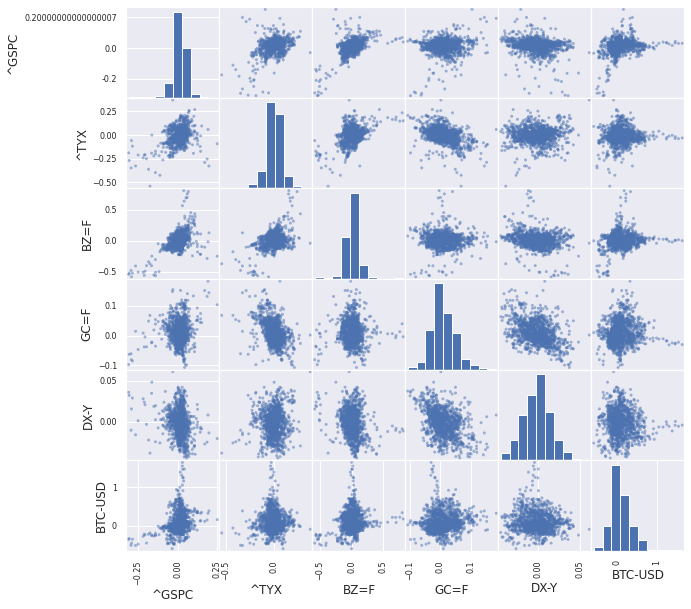

In [28]:
pd.plotting.scatter_matrix(factor_pct_df, figsize=(10,10))

In [29]:
#reset index for spark SQL
price_pct_df = price_pct_df.reset_index()
factor_pct_df = factor_pct_df.reset_index()

## Spark SQL

In [30]:
#set up
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [31]:
# Create a Spark DataFrame from a pandas DataFrame
price_pct_sdf = sqlContext.createDataFrame(price_pct_df)
factor_pct_sdf = sqlContext.createDataFrame(factor_pct_df)

In [32]:
price_pct_sdf.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- BA: double (nullable = true)
 |-- GM: double (nullable = true)
 |-- CVX: double (nullable = true)
 |-- C: double (nullable = true)
 |-- BAC: double (nullable = true)
 |-- T: double (nullable = true)
 |-- CAT: double (nullable = true)
 |-- INTC: double (nullable = true)
 |-- MSFT: double (nullable = true)
 |-- AA: double (nullable = true)
 |-- F: double (nullable = true)
 |-- EBAY: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- CSCO: double (nullable = true)
 |-- DE: double (nullable = true)
 |-- FDX: double (nullable = true)
 |-- GIS: double (nullable = true)
 |-- GLW: double (nullable = true)
 |-- GT: double (nullable = true)
 |-- GS: double (nullable = true)
 |-- JPM: double (nullable = true)
 |-- KMB: double (nullable = true)
 |-- KHC: double (nullable = true)
 |-- KO: double (nullable = true)
 |-- MCD: double (nullable = true)
 |-- LLY: double (nullable = true)
 |-- ORCL: double (nullable = true)
 |-- MRK: double (n

In [33]:
factor_pct_sdf.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- ^GSPC: double (nullable = true)
 |-- ^TYX: double (nullable = true)
 |-- BZ=F: double (nullable = true)
 |-- GC=F: double (nullable = true)
 |-- DX-Y: double (nullable = true)
 |-- BTC-USD: double (nullable = true)



In [34]:
price_pct_sdf.show(3)

+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+---------

In [35]:
factor_pct_sdf.show(3)

+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               Date|               ^GSPC|                ^TYX|                BZ=F|                GC=F|                DX-Y|             BTC-USD|
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|2016-02-02 00:00:00|-0.05447020511215894|-0.10401341395549257|-0.12090273649687422| 0.04855369214731664|                 0.0| -0.1354057343797983|
|2016-02-03 00:00:00|-0.05165836122126122|-0.10162736719130638| -0.0378911950246793|  0.0583271726539869|-0.02122736999960928|-0.14355724501067335|
|2016-02-04 00:00:00|-0.03758808307792...| -0.0816326547162195|0.006719238834710817|0.060170299205855704|-0.02732404795456...| -0.0920777335013736|
+-------------------+--------------------+--------------------+--------------------+--------------------+-------

## Linear Regression by PySpark

In [36]:
#Library
from pyspark.ml.regression import LinearRegression as SparkLinearRegression
from pyspark.ml.feature import VectorAssembler

First, we need to assemble vector for explanatory variables and target variable.

In [37]:
explanatoryVariables = ['^GSPC','^TYX','BZ=F','GC=F','DX-Y','BTC-USD']
vectorAssembler = VectorAssembler(inputCols = explanatoryVariables,
                                  outputCol = 'features')
x_sdf = vectorAssembler.transform(factor_pct_sdf).select(['Date','features'])
y_sdf  = price_pct_sdf.select(price_pct_sdf.columns[0],price_pct_sdf.columns[1])
y_sdf = y_sdf.withColumnRenamed(y_sdf.columns[1],'target')

In [38]:
x_sdf.take(3)

[Row(Date=datetime.datetime(2016, 2, 2, 0, 0), features=DenseVector([-0.0545, -0.104, -0.1209, 0.0486, 0.0, -0.1354])),
 Row(Date=datetime.datetime(2016, 2, 3, 0, 0), features=DenseVector([-0.0517, -0.1016, -0.0379, 0.0583, -0.0212, -0.1436])),
 Row(Date=datetime.datetime(2016, 2, 4, 0, 0), features=DenseVector([-0.0376, -0.0816, 0.0067, 0.0602, -0.0273, -0.0921]))]

In [39]:
y_sdf.take(3)

[Row(Date=datetime.datetime(2016, 2, 2, 0, 0), target=-0.16355874275397575),
 Row(Date=datetime.datetime(2016, 2, 3, 0, 0), target=-0.13610266946048755),
 Row(Date=datetime.datetime(2016, 2, 4, 0, 0), target=-0.10963049067178365)]

In [40]:
#Join both x and y dataframes
regress_df = x_sdf.join(y_sdf, x_sdf['Date'] == y_sdf['Date'], 'inner')

In [41]:
regress_df.take(3)

[Row(Date=datetime.datetime(2016, 3, 11, 0, 0), features=DenseVector([0.1056, 0.0974, 0.3436, 0.0087, 0.0064, 0.1107]), Date=datetime.datetime(2016, 3, 11, 0, 0), target=0.14929910040125383),
 Row(Date=datetime.datetime(2019, 6, 18, 0, 0), features=DenseVector([0.0273, -0.0998, -0.1366, 0.0552, -0.003, 0.1645]), Date=datetime.datetime(2019, 6, 18, 0, 0), target=0.060007319927998015),
 Row(Date=datetime.datetime(2020, 3, 31, 0, 0), features=DenseVector([-0.1394, -0.1712, -0.5615, -0.0357, 0.0196, -0.2482]), Date=datetime.datetime(2020, 3, 31, 0, 0), target=-0.4685339534434556)]

In [42]:
#Set and train linear regression, using PySpark SQL dataframe and Mllib.
lr = SparkLinearRegression(featuresCol = 'features', labelCol = 'target',
                      maxIter=10)
lr_model = lr.fit(regress_df)

In [43]:
#print results.
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

RMSE: 0.087826
r2: 0.529423
Coefficients: [1.3823654746087082,0.0772128755106095,0.22915162868789346,-0.4045537528445681,-1.2704268739279583,0.011519166046122247]
Intercept: 7.284113294728563e-05


Trying linear regression using SySpark. However, in local PC environment, it does not necessarily faster than pandas and scikit-learn. Also, we can run fast enough by local environment using pandas and sklearn for 3000 stocks of linear regression. We can use pandas and scikit-learn to obtain regression coefficients for all stocks y this time.

In [44]:
start = time.time()

#Applying linear regression to all stocks.
#X=factors, y=2 weeks return of each stocks
coef_df = []
#Set and train linear regression, using PySpark SQL dataframe and Mllib.
lr = SparkLinearRegression(featuresCol = 'features', labelCol = 'target',
                      maxIter=10)

#for i in range(1,len(price_pct_sdf.columns+1)):
for i in range(1,10):

  y_sdf  = price_pct_sdf.select(price_pct_sdf.columns[0],price_pct_sdf.columns[i])
  y_sdf = y_sdf.withColumnRenamed(y_sdf.columns[1],'target')

  #Join both x and y dataframes
  regress_sdf = x_sdf.join(y_sdf, x_sdf['Date'] == y_sdf['Date'], 'inner')
  lr_model = lr.fit(regress_sdf)

  if i == 0:
    coef_df = lr_model.coefficients
  else:
    coef_df.append(lr_model.coefficients)

end_time = time.time() - start
print('elapsed time:{}'.format(end_time) + '[sec]')

elapsed time:118.03816437721252[sec]


In [45]:
coef_df

[DenseVector([1.3824, 0.0772, 0.2292, -0.4046, -1.2704, 0.0115]),
 DenseVector([1.2179, 0.281, 0.0443, 0.0265, -0.1402, -0.0175]),
 DenseVector([1.1996, -0.0691, 0.115, 0.0405, 0.3281, 0.0192]),
 DenseVector([1.4442, 0.1323, 0.1143, -0.5981, -0.6203, 0.0191]),
 DenseVector([1.3189, 0.3375, -0.0238, -0.4507, 0.0006, 0.0118]),
 DenseVector([0.5464, -0.1028, 0.0707, -0.0976, -0.2653, 0.0131]),
 DenseVector([0.9421, 0.2217, 0.0138, 0.0435, -0.6643, 0.0096]),
 DenseVector([0.9957, -0.002, 0.0132, -0.0392, 1.1708, -0.0273]),
 DenseVector([1.0363, -0.0488, -0.0735, -0.0139, 0.428, -0.0021])]

##Linear regression by pandas and sklearn.

In [46]:
#Setting linear regression, using sklearn.
skLinearModel = skLinearRegression()

In [47]:
#Applying linear regression to all stocks.
#X=factors, y=2 weeks return of each stocks
X = factor_pct_df.iloc[:,1:]
y = price_pct_df.iloc[:,1:]

coef_df = pd.DataFrame()
for i, column in enumerate(range(len(y.columns))):

  Y = y.iloc[:,column]
  skLinearModel.fit(X, Y)
  temp_df = pd.DataFrame(skLinearModel.coef_).T
  temp_df.index = [y.columns[column]]

  if i == 0:
    coef_df = temp_df
  else:
    coef_df = pd.concat([coef_df,temp_df],axis=0)

As we can see below, I can get same coefficients figures for each stocks.

In [48]:
coef_df.reset_index()

,index,0,1,2,3,4,5
0,BA,1.382365,0.077213,0.229152,-0.404554,-1.270427,0.011519
1,GM,1.217906,0.281039,0.044343,0.026546,-0.140242,-0.017501
2,CVX,1.199605,-0.069128,0.115046,0.040476,0.328077,0.019181
3,C,1.444200,0.132288,0.114250,-0.598140,-0.620259,0.019139
4,BAC,1.318886,0.337464,-0.023794,-0.450654,0.000633,0.011774
...,...,...,...,...,...,...,...
3710,GNL,1.127503,-0.199217,0.181885,0.016143,0.399613,-0.016892
3711,LNTH,1.430557,-0.275408,0.080497,-0.316991,0.346367,-0.001544
3712,GATX,0.810429,0.169266,0.078832,-0.363565,-0.115465,-0.001404
3713,MTDR,2.729141,0.155467,0.597610,0.520848,0.138848,0.068029


## k-means using PySpark

In [49]:
coef_sdf = sqlContext.createDataFrame(coef_df.reset_index())

In [50]:
coef_sdf.show()

+-----+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|                 0|                   1|                   2|                   3|                   4|                   5|
+-----+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   BA| 1.382365474608708| 0.07721287551060899| 0.22915162868789354| -0.4045537528445682| -1.2704268739279587|0.011519166046121992|
|   GM|1.2179055651297348| 0.28103860574908374|0.044343445960021655| 0.02654567153395271|-0.14024190606679246|-0.01750138766029...|
|  CVX|1.1996046183862263|-0.06912792329728719| 0.11504647041755567| 0.04047567425270537|  0.3280772145025979|0.019181010534091148|
|    C|1.4441997160598352| 0.13228752445803077| 0.11425000304183928| -0.5981399702880346| -0.6202591280976714|0.019139338331789685|
|  BAC|1.3188861139215802|  0.3374644394268512|-0.02379438056497...|-0.45065

In [51]:
#vectorizing.
explanatoryVariables = ['0','1','2','3','4','5']
vectorAssembler = VectorAssembler(inputCols = explanatoryVariables,
                                  outputCol = 'features')
coef_vector_sdf = vectorAssembler.transform(coef_sdf).select(['index','features'])

In [52]:
coef_vector_sdf.take(3)

[Row(index='BA', features=DenseVector([1.3824, 0.0772, 0.2292, -0.4046, -1.2704, 0.0115])),
 Row(index='GM', features=DenseVector([1.2179, 0.281, 0.0443, 0.0265, -0.1402, -0.0175])),
 Row(index='CVX', features=DenseVector([1.1996, -0.0691, 0.115, 0.0405, 0.3281, 0.0192]))]

In [53]:
#standardizing data, because the scale of each coefficients can affect euclid distance.
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale = scale.fit(coef_vector_sdf)
scaled_coefvector_sdf = data_scale.transform(coef_vector_sdf)

In [54]:
scaled_coefvector_sdf.take(3)

[Row(index='BA', features=DenseVector([1.3824, 0.0772, 0.2292, -0.4046, -1.2704, 0.0115]), standardized=DenseVector([0.4989, 0.0259, 0.2323, -0.0622, -0.1262, 0.0165])),
 Row(index='GM', features=DenseVector([1.2179, 0.281, 0.0443, 0.0265, -0.1402, -0.0175]), standardized=DenseVector([0.4395, 0.0941, 0.0449, 0.0041, -0.0139, -0.0251])),
 Row(index='CVX', features=DenseVector([1.1996, -0.0691, 0.115, 0.0405, 0.3281, 0.0192]), standardized=DenseVector([0.4329, -0.0231, 0.1166, 0.0062, 0.0326, 0.0275]))]

In [55]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,50):
    
    kmeans=KMeans(featuresCol='standardized').setK(i).setSeed(42)
    model=kmeans.fit(scaled_coefvector_sdf)    
    prediction=model.transform(scaled_coefvector_sdf)    
    score=evaluator.evaluate(prediction)
    silhouette_score.append(score)
    
    print("Silhouette Score {0}:{1}".format(i,score))

Silhouette Score 2:0.9995920453680149
Silhouette Score 3:0.9994261146376942
Silhouette Score 4:0.9844851277946887
Silhouette Score 5:0.3338370532603875
Silhouette Score 6:0.35433905435709534
Silhouette Score 7:0.32841042017767796
Silhouette Score 8:0.3322629216486543
Silhouette Score 9:0.22405365016112966
Silhouette Score 10:0.26561583959448765
Silhouette Score 11:0.22318317419989217
Silhouette Score 12:0.18810029533699574
Silhouette Score 13:0.21887184047957486
Silhouette Score 14:0.24862641550756887
Silhouette Score 15:0.23106006525876382
Silhouette Score 16:0.2378804075417985
Silhouette Score 17:0.1824938670612156
Silhouette Score 18:0.21488280313093336
Silhouette Score 19:0.1909984837056101
Silhouette Score 20:0.20129026252355395
Silhouette Score 21:0.19738322630541896
Silhouette Score 22:0.21268339276359585
Silhouette Score 23:0.21963064134566207
Silhouette Score 24:0.2049028089666887
Silhouette Score 25:0.203961818460663
Silhouette Score 26:0.17965734480891357
Silhouette Score 27

k=14 looks good, because Silhouette score looks the local optima, while the number of cluster k is enough large to work as clustering / classification. 

Text(0, 0.5, 'cost')

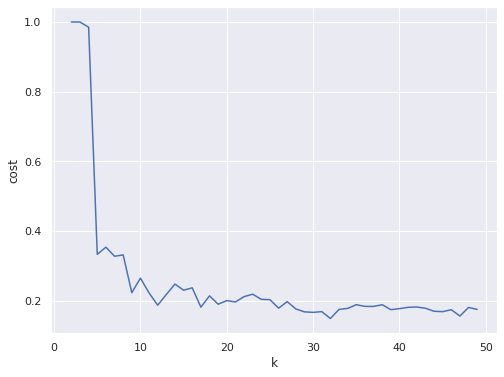

In [56]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,50),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [57]:
# Trains a k-means model.
kmeans=KMeans(featuresCol='standardized').setK(14).setSeed(42)
model=kmeans.fit(scaled_coefvector_sdf)
prediction=model.transform(scaled_coefvector_sdf)    
score=evaluator.evaluate(prediction)

In [58]:
score

0.24862641550756887

In [59]:
# Shows the result of 14 centroids.
print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)

Cluster Centers: 
[ 0.47412223 -0.00367226  0.24012444 -0.03048449 -0.06360364 -0.01030693]
[ 54.30717621 -51.72764152  26.48727957 -37.41229494 -31.81920214
 -59.73588474]
[ 24.88129519 -31.13523294  53.24264769 -47.63975566 -51.41603969
  10.74213881]
[ 0.42397862 -0.03616946  0.69543922 -0.04208327 -0.1168646  -0.03192093]
[-2.84169255  3.19781594 -2.57588552  0.87671691 -1.1816338  -0.67546693]
[ 0.20200186  0.01477705  0.06778685  0.00974706 -0.03570773  0.00842972]
[ 3.43871231 -2.16058696  3.4308238  -3.78378722 -3.57365873  1.27639604]
[ 5.18373007 -0.81687415 -2.81854318  0.33057073  0.32209875 -0.18643254]
[ 0.77273529 -0.00491899 -0.09017906 -0.01591348 -0.04585301 -0.03237529]
[-0.28326994  0.05949245  2.17724203 -0.06156039 -0.19753915 -0.09876312]
[ 0.42342768  0.01611864  0.00073282 -0.01541142 -0.02442696 -0.00429058]
[-3.51566849 -4.87574221  0.30246753  1.1234583   2.63584463 -0.56362322]
[ 0.54723235 -0.15098639  0.20741334 -0.32101278 -0.72659466  1.63647958]
[-0.08

In [60]:
prediction.take(3)

[Row(index='BA', features=DenseVector([1.3824, 0.0772, 0.2292, -0.4046, -1.2704, 0.0115]), standardized=DenseVector([0.4989, 0.0259, 0.2323, -0.0622, -0.1262, 0.0165]), prediction=0),
 Row(index='GM', features=DenseVector([1.2179, 0.281, 0.0443, 0.0265, -0.1402, -0.0175]), standardized=DenseVector([0.4395, 0.0941, 0.0449, 0.0041, -0.0139, -0.0251]), prediction=10),
 Row(index='CVX', features=DenseVector([1.1996, -0.0691, 0.115, 0.0405, 0.3281, 0.0192]), standardized=DenseVector([0.4329, -0.0231, 0.1166, 0.0062, 0.0326, 0.0275]), prediction=10)]

In [61]:
prediction_df = prediction.toPandas()

In [62]:
prediction_df.head()

,index,features,standardized,prediction
0,BA,"[1.382365474608708, 0.07721287551060899, 0.229...","[0.49888767050541927, 0.025852082785877185, 0....",0
1,GM,"[1.2179055651297348, 0.28103860574908374, 0.04...","[0.43953504441735725, 0.09409613686585921, 0.0...",10
2,CVX,"[1.1996046183862263, -0.06912792329728719, 0.1...","[0.4329303390361721, -0.02314511386966401, 0.1...",10
3,C,"[1.4441997160598352, 0.13228752445803077, 0.11...","[0.5212032890893935, 0.04429193979905426, 0.11...",0
4,BAC,"[1.3188861139215802, 0.3374644394268512, -0.02...","[0.4759783379446226, 0.11298839173725504, -0.0...",10


Then, we can create recommendation system. By input ticker code, we can search same category of stocks, calculate euclidian distance between the each stock, then we can sort the most closest distance's stocks.

In [63]:
from scipy.spatial import distance

def recommendSimilar(ticker, num_reco):
  standardized_vector = prediction_df[prediction_df['index']==ticker]['standardized'].values[0]
  prediction_category = prediction_df[prediction_df['index']==ticker]['prediction'].values[0]
  same_category_df = prediction_df[prediction_df['prediction']==prediction_category]
  same_category_df['euclidian'] = same_category_df['standardized'].apply(
      lambda x: distance.euclidean(standardized_vector, x.values))
  same_category_sorted_df = same_category_df.sort_values(by='euclidian',ascending=True).iloc[1:,:]
  return same_category_sorted_df.head(num_reco)

In [67]:
recommendSimilar('C', 10)

,index,features,standardized,prediction,euclidian
391,TXT,"[1.4977515445713987, 0.14322056523342308, 0.09...","[0.5405298329507424, 0.04795249347430209, 0.10...",0,0.044127
320,DFS,"[1.4450409361692236, 0.24459848184661043, 0.13...","[0.5215068805407598, 0.08189541135700383, 0.13...",0,0.057967
3270,VC,"[1.5214289174674662, 0.24241208325075608, 0.13...","[0.5490748593021499, 0.08116337078567211, 0.13...",0,0.061643
2283,CMSQY,"[1.307124861512019, 0.12385346626898064, 0.130...","[0.47173377026363855, 0.041468084722004694, 0....",0,0.072595
1781,NAV,"[1.4789924963415395, 0.175493633455668, 0.1454...","[0.5337598014039532, 0.05875802332820713, 0.14...",0,0.075200
1776,JBT,"[1.303225431824341, 0.08407582672611635, 0.112...","[0.4703264887386598, 0.02814990658541118, 0.11...",0,0.076695
47,BB,"[1.4931407461321793, 0.05045428386168194, 0.13...","[0.5388658225752205, 0.016892886253344265, 0.1...",0,0.077009
349,WYND,"[1.5164324470332828, 0.2451759696481594, 0.115...","[0.5472716621437685, 0.08208876333819545, 0.11...",0,0.080146
3636,AIR,"[1.4492487162344285, 0.23965244575774755, 0.17...","[0.523025443925977, 0.08023940083303817, 0.180...",0,0.080914
1957,HHC,"[1.3550567396914113, 0.012595400015218292, 0.1...","[0.48903210669282005, 0.00421713764396616, 0.1...",0,0.082434


In [ ]:
ticker = 'AMZN'
standardized_vector = prediction_df[prediction_df['index']==ticker]['standardized'].values[0]
prediction_category = prediction_df[prediction_df['index']==ticker]['prediction'].values[0]

In [ ]:
prediction_category

10

In [ ]:
standardized_vector

DenseVector([0.3779, -0.0465, -0.0216, -0.018, -0.0035, -0.0151])

In [ ]:
same_category_df = prediction_df[prediction_df['prediction']==prediction_category]

In [ ]:
same_category_df.head()

,index,features,standardized,prediction
1,GM,"[1.2179055651297348, 0.28103860574908374, 0.04...","[0.43953504441735725, 0.09409613686585921, 0.0...",10
2,CVX,"[1.1996046183862263, -0.06912792329728719, 0.1...","[0.4329303390361721, -0.02314511386966401, 0.1...",10
4,BAC,"[1.3188861139215802, 0.3374644394268512, -0.02...","[0.4759783379446226, 0.11298839173725504, -0.0...",10
6,CAT,"[0.942066015489152, 0.22172246093315545, 0.013...","[0.3399861531283825, 0.07423616045415618, 0.01...",10
7,INTC,"[0.9956850543962085, -0.0019969951058318725, 0...","[0.3593369528310824, -0.0006686253096721375, 0...",10


In [ ]:
from scipy.spatial import distance

In [ ]:
same_category_df['euclidian'] = same_category_df['standardized'].apply(
    lambda x: distance.euclidean(standardized_vector, x.values))

In [ ]:
same_category_sorted_df = same_category_df.sort_values(by='euclidian',ascending=True)

In [ ]:
same_category_sorted_df.head(10)

,index,features,standardized,prediction,euclidian
84,AMZN,"[1.0471122623743607, -0.13891162880891783, -0....","[0.3778967334824911, -0.04650979391896581, -0....",10,0.000000
201,SHW,"[1.101632085859532, -0.14460784299948426, -0.0...","[0.39757262110734864, -0.048416975847456196, -...",10,0.028225
287,AVB,"[1.0337996238772469, -0.17457151169241758, -0....","[0.3730922795735233, -0.05844928248667566, -0....",10,0.029818
2135,STE,"[1.0215271783275308, -0.15115435388962062, -0....","[0.3686632252574529, -0.05060885045866917, -0....",10,0.035900
1102,ICLR,"[1.050615245850305, -0.17635155221969, -0.0173...","[0.3791609398723588, -0.059045267997757174, -0...",10,0.037047
3206,UFPT,"[0.9925816841893981, -0.13939005062417106, 0.0...","[0.3582169645489461, -0.04666997705283701, 0.0...",10,0.042812
1839,MUSA,"[0.9982131971245692, -0.24262057642498464, -0....","[0.3602493448573764, -0.08123317757326812, -0....",10,0.044225
1390,ESS,"[1.0204393615701841, -0.11600668246123429, -0....","[0.3682706385081614, -0.0388408583266755, -0.0...",10,0.048050
3670,PHG,"[1.0641685085635593, -0.08712139207560093, 0.0...","[0.38405223366329877, -0.029169609672804374, 0...",10,0.050363
43,GOOGL,"[1.1202190122409468, -0.0444294655452006, -0.0...","[0.40428053487878046, -0.014875682505167005, -...",10,0.053112


## Random Forest Regression by PySpark

In [ ]:
from pyspark.ml.regression import RandomForestRegressor as SparkRandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
#Set and train linear regression, using PySpark SQL dataframe and Mllib.
rf = SparkRandomForestRegressor(featuresCol = 'features', labelCol = 'target')

In [ ]:
#Data preprocessing
y_sdf  = price_pct_sdf.select(price_pct_sdf.columns[0],price_pct_sdf.columns[1])
y_sdf = y_sdf.withColumnRenamed(y_sdf.columns[1],'target')
#Join both x and y dataframes
regress_sdf = x_sdf.join(y_sdf, x_sdf['Date'] == y_sdf['Date'], 'inner')
regress_sdf = regress_sdf.drop('Date')

In [ ]:
# Chain indexer and forest in a Pipeline
rf_model = rf.fit(regress_sdf)
# Make predictions.
rf_predictions = rf_model.transform(regress_sdf)

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="target", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE): {0}".format(rmse))

Root Mean Squared Error (RMSE): 0.06857654858612201


In [ ]:
rf_predictions_df = rf_predictions.toPandas()

In [ ]:
def plotting(target_col, prediction_col):
  plt.plot(target_col, label='actual return')
  plt.plot(prediction_col, label='prediction return')
  plt.xlabel("Time-series about 5 years")
  plt.ylabel("Rolling 20 days return")
  plt.legend()
  plt.show()

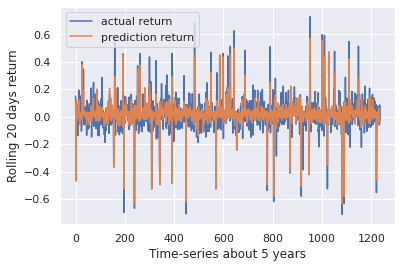

In [ ]:
plotting(rf_predictions_df['target'], rf_predictions_df['prediction'])

We can also obtain the importance of each features i.e. this case, S&P500('^GSPC'), 30 years treasury yield('^TYX'), crude oil price('BZ=F'), gold price('GC=F'), dollar index('DX-Y'), bitcoin('BTC-USD').

In [ ]:
importances = rf_model.featureImportances

As we can see below chart, in this case, S&P500 and Crude oil price performed as important features.

Text(0.5, 1.0, 'Feature Importances')

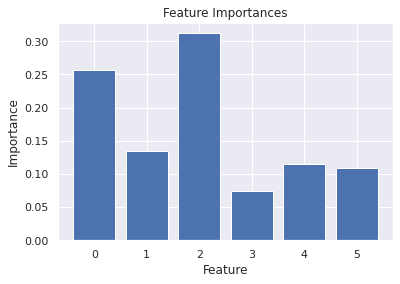

In [ ]:
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

Usually, RMSE of RandomForest is smaller i.e. better than that of LinearRegression, because random forest can take non-linearity of data and can get result from ensembling method i.e. voting by many models.

In [ ]:
#Compared with linear regression
#Set and train linear regression, using PySpark SQL dataframe and Mllib.
lr = SparkLinearRegression(featuresCol = 'features', labelCol = 'target',
                      maxIter=10)
lr_model = lr.fit(regress_sdf)
lr_predictions = lr_model.transform(regress_sdf)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="target", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(lr_predictions)
print("Root Mean Squared Error (RMSE): {0}".format(rmse))

##print results.
#trainingSummary = lr_model.summary
#print("RMSE: %f" % trainingSummary.rootMeanSquaredError)

Root Mean Squared Error (RMSE): 0.08782592823317754


In [ ]:
lr_predictions_df = lr_predictions.toPandas()

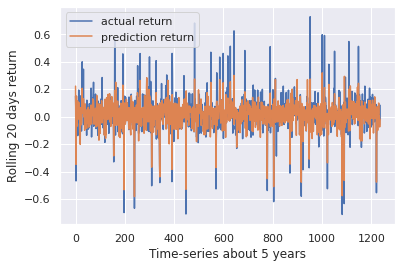

In [ ]:
plotting(lr_predictions_df['target'], lr_predictions_df['prediction'])

Below is the comparison of RMSE between RandomForest and LinearRegression, for first 10 stocks by PySpark.

In [ ]:
start = time.time()

#Set and train linear regression, using PySpark SQL dataframe and Mllib.
rf = SparkRandomForestRegressor(featuresCol = 'features', labelCol = 'target')
lr = SparkLinearRegression(featuresCol = 'features', labelCol = 'target',
                      maxIter=10)

rmse_results = []
model_importance = []
for i in range(1,11):

  #Data preprocessing
  y_sdf  = price_pct_sdf.select(price_pct_sdf.columns[0],price_pct_sdf.columns[i])
  y_sdf = y_sdf.withColumnRenamed(y_sdf.columns[1],'target')
  #Join both x and y dataframes
  regress_sdf = x_sdf.join(y_sdf, x_sdf['Date'] == y_sdf['Date'], 'inner')
  regress_sdf = regress_sdf.drop('Date')

  # Chain indexer and forest in a Pipeline
  rf_model = rf.fit(regress_sdf)
  # Make predictions.
  rf_predictions = rf_model.transform(regress_sdf)

  #Linear Regression
  lr_model = lr.fit(regress_sdf)
  lr_predictions = lr_model.transform(regress_sdf)

  # Select (prediction, true label) and compute test error
  evaluator = RegressionEvaluator(
      labelCol="target", predictionCol="prediction", metricName="rmse")
  rf_rmse = evaluator.evaluate(rf_predictions)
  lr_rmse = evaluator.evaluate(lr_predictions)
  temp_list = [rf_rmse, lr_rmse]
  rmse_results.append(temp_list)

  #get importance
  importances = rf_model.featureImportances
  model_importance.append(importances)

  print("RMSE of RandomForest: {0}".format(rf_rmse))
  print("RMSE of LinearRegression: {0}".format(lr_rmse))
  print("Difference of RMSE between RandomForestRegression - LinearRegression: {0}".format(rf_rmse - lr_rmse))

RMSE of RandomForest: 0.06857654858612201
RMSE of LinearRegression: 0.08782592823317754
Difference of RMSE between RandomForestRegression - LinearRegression: -0.01924937964705553
RMSE of RandomForest: 0.05972284250063204
RMSE of LinearRegression: 0.06776101829724004
Difference of RMSE between RandomForestRegression - LinearRegression: -0.008038175796608003
RMSE of RandomForest: 0.04341133528134547
RMSE of LinearRegression: 0.05387686360341871
Difference of RMSE between RandomForestRegression - LinearRegression: -0.010465528322073238
RMSE of RandomForest: 0.045840098154258234
RMSE of LinearRegression: 0.0502236690407887
Difference of RMSE between RandomForestRegression - LinearRegression: -0.0043835708865304635
RMSE of RandomForest: 0.04308100365981173
RMSE of LinearRegression: 0.047382652391972625
Difference of RMSE between RandomForestRegression - LinearRegression: -0.004301648732160893
RMSE of RandomForest: 0.03916639622857308
RMSE of LinearRegression: 0.046805372748629774
Difference

In [ ]:
rmse_results_df = pd.DataFrame(rmse_results, columns=['rf_rmse','lr_rmse'])
rmse_results_df['diff']= rmse_results_df['rf_rmse'] - rmse_results_df['lr_rmse']

In [ ]:
rmse_results_df

,rf_rmse,lr_rmse,diff
0,0.068577,0.087826,-0.019249
1,0.059723,0.067761,-0.008038
2,0.043411,0.053877,-0.010466
3,0.045840,0.050224,-0.004384
4,0.043081,0.047383,-0.004302
5,0.039166,0.046805,-0.007639
6,0.049607,0.056706,-0.007099
7,0.054032,0.063992,-0.009960
8,0.032531,0.033310,-0.000779
9,0.093371,0.115461,-0.022090


In [ ]:
importance_df = pd.DataFrame(model_importance)

In [ ]:
importance_df[0][1]

SparseVector(6, {0: 0.3392, 1: 0.2453, 2: 0.2119, 3: 0.0646, 4: 0.0664, 5: 0.0726})

In [ ]:
important_list = []
for i in range(len(importance_df)):
  temp_list = [importance_df[0][i][0],
               importance_df[0][i][1],
               importance_df[0][i][2],
               importance_df[0][i][3],
               importance_df[0][i][4],
               importance_df[0][i][5]]
  important_list.append(temp_list)

In [ ]:
important_list

[[0.256317889344619,
  0.13475938006953334,
  0.31200322598629215,
  0.07403043137646564,
  0.11448544423331887,
  0.10840362898977109],
 [0.33915273954742814,
  0.2453244879902381,
  0.21185273710546124,
  0.06461262338453833,
  0.06643244788068015,
  0.07262496409165399],
 [0.33410849022997213,
  0.10477587614516944,
  0.2682431460045477,
  0.06792318609429668,
  0.05792193554289221,
  0.16702736598312182],
 [0.3521419424516813,
  0.21980963652293295,
  0.2345379578054687,
  0.06728230656481148,
  0.039880199561917844,
  0.08634795709318778],
 [0.32395169117343214,
  0.3299540623049016,
  0.1668382960598675,
  0.09183964910893391,
  0.035929890398012886,
  0.05148641095485192],
 [0.34732808017573835,
  0.09206305021142472,
  0.2308005252695043,
  0.06641477800325427,
  0.13079462450965007,
  0.1325989418304284],
 [0.3567603600160989,
  0.19982254534730684,
  0.23624545604073882,
  0.05650514769634877,
  0.08975929895346155,
  0.06090719194604508],
 [0.2820080323524866,
  0.1777045295

In [ ]:
important_df2 = pd.DataFrame(important_list)

In [ ]:
important_df2

,0,1,2,3,4,5
0,0.256318,0.134759,0.312003,0.074030,0.114485,0.108404
1,0.339153,0.245324,0.211853,0.064613,0.066432,0.072625
2,0.334108,0.104776,0.268243,0.067923,0.057922,0.167027
3,0.352142,0.219810,0.234538,0.067282,0.039880,0.086348
4,0.323952,0.329954,0.166838,0.091840,0.035930,0.051486
5,0.347328,0.092063,0.230801,0.066415,0.130795,0.132599
6,0.356760,0.199823,0.236245,0.056505,0.089759,0.060907
7,0.282008,0.177705,0.154619,0.128422,0.147988,0.109259
8,0.467560,0.133905,0.122772,0.085402,0.051673,0.138688
9,0.242425,0.149727,0.314723,0.064092,0.167703,0.061330


From first 10 stocks, we can see that S&P500('^GSPC'), 30 years treasury yield('^TYX'), and crude oil price('BZ=F') were important features, which is natural as the stock price driving factor, in terms of my domain knowledge.

Text(0.5, 1.0, 'Feature Importances')

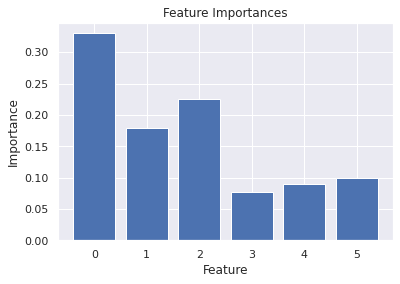

In [ ]:
x_values = list(range(len(important_df2.mean(axis=0))))
plt.bar(x_values, important_df2.mean(axis=0), orientation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')